In [1]:
%load_ext autoreload
%aimport gempipe, gempipe.interface, gempipe.interface.sanity, gempipe.interface.gaps, gempipe.interface.medium
%autoreload 1

## _Tutorial:_ multi-strain analysis

Using `gempipe derive`, we generated GSMMs for 45 randomly picked strains belonging to 3 species of _Lacticaseibacillus_: _L. casei_, _L. paracasei_, _L. rhamnosus_ (15 each). During the process, the binary feature table `rpam.csv` was generated, showing the presence / absence of metabolic reactions in each strain. Moreover, since we run `gempipe derive` with the options `--cnps` and `--aux`, two other binary feature tables were produced: `cnps.csv` and `aux.csv`. The first include the ability / inability of strains in catabolizing alternative C, N,  and S sources; the second report the presence / absence of auxotrophies for specific amino acids and vitamins. 

These tables have always the same structure: binary metabolic feature in row, strains (genome accessions) in column. As the features are binary, cells contain either 1 (feature present) or 0 (feature absent). Below we see the table for alternative substrates(`cnps.csv`): IDs are preceded by the source type (C, N, P and S), and substrates can be repeated if a they are considered source of multiple types of atoms at the same time (for example, methionine `met__L`, having chemical formula `C5H11NO2S`, it will be tested as C, N and S source, so it will appear in three separated rows).

In [6]:
import pandas as pnd

aux = pnd.read_csv('tutoring_materials/lacticaseibacillus/aux.csv', index_col=0)
cnps = pnd.read_csv('tutoring_materials/lacticaseibacillus/cnps.csv', index_col=0)
rpam = pnd.read_csv('tutoring_materials/lacticaseibacillus/rpam.csv', index_col=0)

cnps

,GCA_025190575.1,GCA_000026525.1,GCA_005864085.1,GCA_001013375.1,GCA_024329605.1,GCA_959021285.1,GCA_000311965.1,GCA_024329385.1,GCA_025190605.1,GCA_026427555.1,...,GCA_002091975.1,GCA_007989685.1,GCA_030224505.1,GCA_000735255.1,GCA_030480425.1,GCA_032466035.1,GCA_030215365.1,GCA_030361365.1,GCA_028578865.1,GCA_002091995.1
[C]melib,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
[C]Larab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
[C]acald,1,0,0,1,0,0,0,1,1,0,...,1,0,0,0,1,0,0,0,0,0
[C]serglugly,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
[C]pacald,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[S]met__L,1,1,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,1,0,0
[S]h2s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
[S]gly_met,1,1,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,1,0,0
[S]taur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we try to build a dendrogram using all these binary metabolic features. We call such dendrogram a **"phylometabolic tree"**, as it resembles a phylogenetic tree, but it is built by using exclusively metabolic features. Then, we split this tree into clusters, which group metabolically homogeneous strains together. 

The assigned data-driven cluster can be compared with a strain-specific metadata such as the isolation niche or, like in this tutorial, the species of origin. This metadaat is provided by one of the `gempipe derive` outputs, namely `derive_strains.csv`:  

In [7]:
report = pnd.read_csv('tutoring_materials/lacticaseibacillus/derive_strains.csv', index_col=0)

report.head()

,species,strain,niche,G,R,M,obj_value,status,R.1,inserted_rids,solver_error,obj_value_gf,status_gf
accession,,,,,,,,,,,,,
GCA_008868595.1,Lacticaseibacillus casei,BIO5773,-,1039,1312,1212,0.0,optimal,1313,{'cdm25_gempipe': ['GLUR']},-,{'cdm25_gempipe': 1.6898873415546019},{'cdm25_gempipe': 'optimal'}
GCA_005864085.1,Lacticaseibacillus casei,FAM 20446,-,948,1255,1212,0.0,optimal,1256,{'cdm25_gempipe': ['ALATA_D']},-,{'cdm25_gempipe': 1.6898873415543527},{'cdm25_gempipe': 'optimal'}
GCA_018363095.1,Lacticaseibacillus casei,FBL6,-,1018,1289,1212,0.0,optimal,1290,{'cdm25_gempipe': ['GLUR']},-,{'cdm25_gempipe': 1.6898873415546252},{'cdm25_gempipe': 'optimal'}
GCA_002091995.1,Lacticaseibacillus casei,GCRL 163,-,1039,1265,1212,0.0,optimal,1266,{'cdm25_gempipe': ['GLUR']},-,{'cdm25_gempipe': 1.7027403931953289},{'cdm25_gempipe': 'optimal'}
GCA_037901485.1,Lacticaseibacillus casei,LC130,-,877,1229,1212,0.0,optimal,1230,{'cdm25_gempipe': ['GLUR']},-,{'cdm25_gempipe': 1.1298198948419083},{'cdm25_gempipe': 'optimal'}


Now we have all the necessary inputs for building the phylometabolic tree, splitting the tree into data-driven clusters, and comparing clusters with a biologically relevant metadata.

First of all, the phylometabolic tree must be built, and the strains assigned to clusters. To this aim, we use the [gempipe.silhouette_analysis](https://gempipe.readthedocs.io/en/latest/autoapi/gempipe/interface/clusters/index.html#gempipe.interface.clusters.silhouette_analysis) function. To divide the phylometabolic tree in clusters, a [Silhouette analysis](https://doi.org/10.1016/0377-0427(87)90125-7) is performed, which evaluates the quality of clustering by measuring how well each data point fits within its own cluster compared to neighboring clusters. The _Silhouette Coefficient_ quantifies the cohesion and separation of individual data points, ranging from -1 (misclassified) to +1 (well-clustered), providing insight into the suitability of cluster assignments. The _Average Silhouette Score_, calculated across all data points, gives an overall measure of clustering efficacy, helping identify optimal cluster numbers and detect poorly formed clusters. 

In the range considered (`ctotest`), the _Average Silhouette score_ have a peak on 4, but higher values can be reached; to avoid the risk of everfitting, and to work with a menagable number of clusters, we extract 4 clusters (`forcen`). We can see that this clusetering appears mostly concordant with the species of origin:

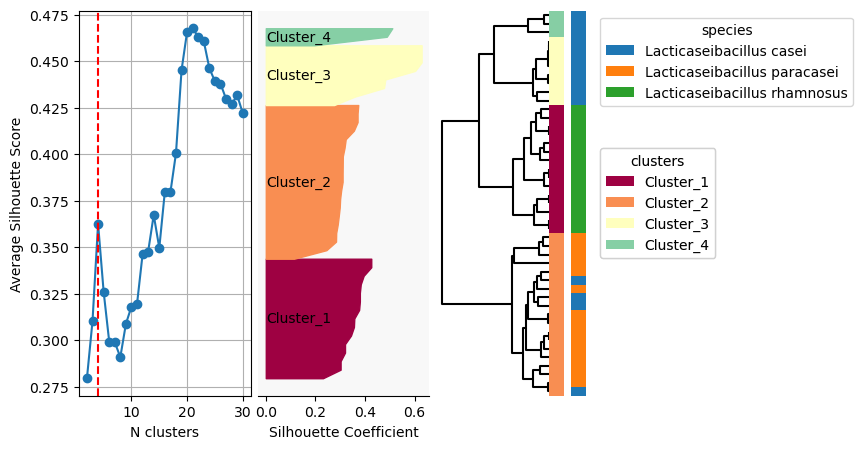

In [8]:
import gempipe

fig, acc_to_cluster, cluster_to_color = gempipe.silhouette_analysis(
    derive_report=report, report_key='species',
    tables={'auxotrophy': aux, 'substrate': cnps, 'reaction': rpam},
    ctotest=range(2,31,1), forcen=4, 
    outfile = 'silhouette_analysis.png',
)

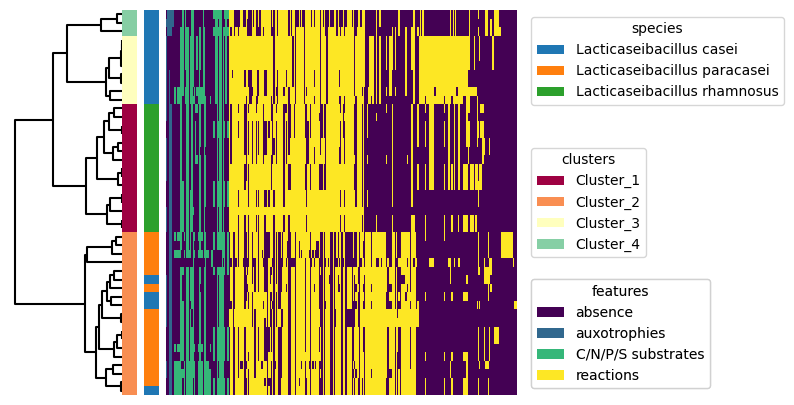

In [4]:
fig, ord_data_bool = gempipe.heatmap_multilayer(
    derive_report=report, 
    tables = {'auxotrophies': aux, 'C/N/P/S substrates': cnps, 'reactions': rpam},
    acc_to_cluster = acc_to_cluster, cluster_to_color = cluster_to_color,
    outfile = 'phylomet_dendro.png')

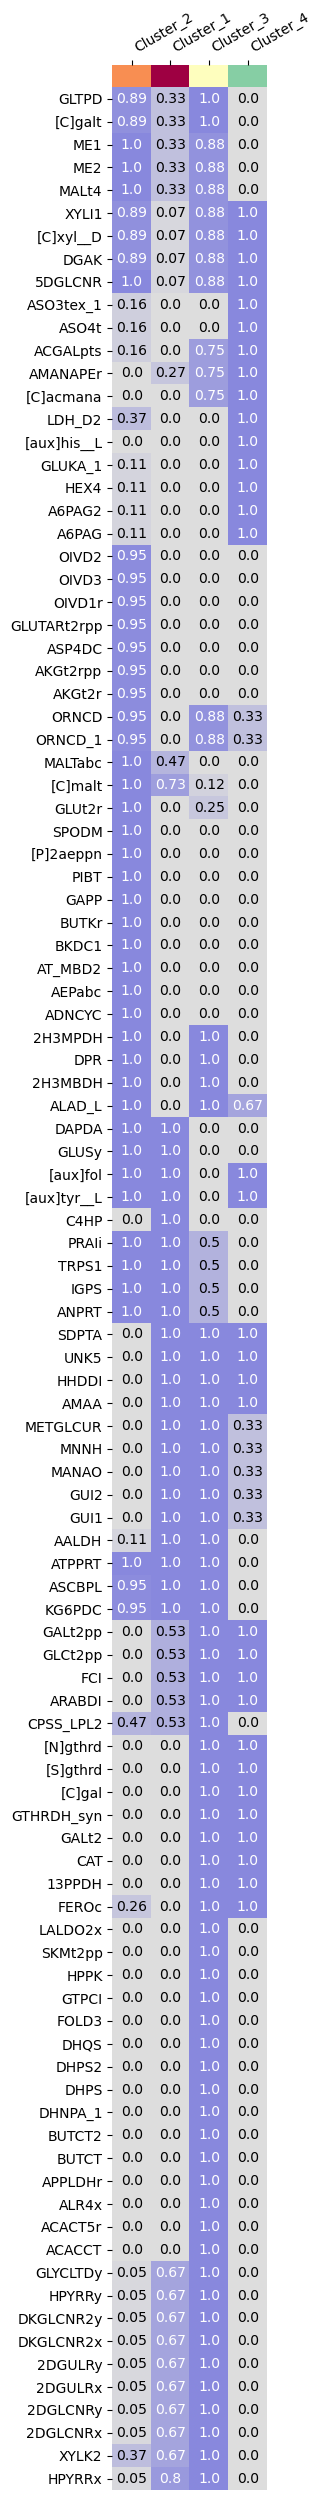

In [5]:
fig, df_relfreq = gempipe.discriminant_feat(ord_data_bool, acc_to_cluster, cluster_to_color)